<a href="https://colab.research.google.com/github/mancunian1792/LatentSpaceClustering_GenerativeModels/blob/main/VAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10 # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.cm as cm
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class encoder(nn.Module):
    def __init__(self, image_channels=3):
        super(encoder, self).__init__()
        self.conv2d1 = nn.Conv2d(image_channels, 32, kernel_size=4, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2d2 = nn.Conv2d(32,64, kernel_size=4, stride=2)
        self.conv2d3 = nn.Conv2d(64,128, kernel_size=4, stride=2)
        # self.conv2d4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.flatten = Flatten()
    
    def forward(self,x):
        x = self.conv2d1(x)
        x = self.relu1(x)
        x = self.conv2d2(x)
        x = self.relu1(x)
        x = self.conv2d3(x)
        x = self.relu1(x)
        # x = self.conv2d4(x)
        x = self.relu1(x)
        return self.flatten(x)

class decoder(nn.Module):
    def __init__(self, h_dim = 1024, image_channels=3):
        super(decoder, self).__init__()
        self.unflatten = UnFlatten()
        self.tranconv1 = nn.ConvTranspose2d(h_dim, h_dim//2, kernel_size=3, stride=2)
        self.tranconv2 = nn.ConvTranspose2d(h_dim//2, h_dim//4, kernel_size=3, stride=2)
        self.tranconv3 = nn.ConvTranspose2d(h_dim//4, h_dim//8, kernel_size=2, stride=2)
        self.tranconv4 = nn.ConvTranspose2d(h_dim//8, image_channels, kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.unflatten(x, size= x.shape[1])
        x = self.tranconv1(x)
        x = self.relu(x)

        x = self.tranconv2(x)
        x = self.relu(x)

        x = self.tranconv3(x)
        x = self.relu(x)

        x = self.tranconv4(x)
        x = self.sig(x)
        return x


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32, use_cuda = False):
        super(VAE, self).__init__()
        self.encoder = encoder(image_channels=image_channels) # the encoded image is 128 channels.
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = decoder(h_dim, image_channels)

        if use_cuda:
          self.cuda()
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().cuda()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        # print(h.shape)
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
use_cuda = True


In [ ]:
'''
# Check image reconstruction Give the actual image to the vae - reconstruct (image -> vae.encode() -> vae.decode() -> reconstructed image)

# Given all training images -> vae.encode() -> get latent representation of the images -> Clustering on the encoded space (bs, z) (t-sne) -> label the points according to their ground truth


# Anomaly detection of images 

# Recommendation of images 
'''

'\n# Check image reconstruction Give the actual image to the vae - reconstruct (image -> vae.encode() -> vae.decode() -> reconstructed image)\n\n# Given all training images -> vae.encode() -> get latent representation of the images -> Clustering on the encoded space (bs, z) (t-sne) -> label the points according to their ground truth\n\n\n# Anomaly detection of images \n\n# Recommendation of images \n'


Repeat for MNIST, Fashion MNISt and CIFAR
- Visually show how my latent space is clustered 
  - Comparison of the visualization in different latent space dimensions

- Do clustering metrics reflect the quality of representation of the original data in the encoded space (Hypothesis may or may not be true)

- For anomaly detection and recommendation systems how does the model perform? 
    - If we give a random image that is not related to the trained set, loss should be high 
    - Recommending a similar generated image : Given a image , get the encoded space , add noise with 0 mean and low SD , reconstruct the image 
    - Recommending other images from the original dataset : Get the encoded space of the given image , use the latent space of the dataset to generate closest images in the encoded space.

### CIFAR10

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(28, 28)), transforms.ToTensor()])
dataloader = DataLoader(
      CIFAR10('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

train_cifar_dataset = CIFAR10('./cifar_data/', download= True, transform= transform, train=True)
train_cifar_loader = DataLoader(train_cifar_dataset, batch_size= batch_size, shuffle= True)


test_cifar_dataset = CIFAR10('./cifar_data/', download= True, transform= transform, train=False)
test_cifar_loader = DataLoader(test_cifar_dataset, batch_size= batch_size, shuffle= False)

use_cuda = True

Extracting ./cifar-10-python.tar.gz to .


Extracting ./cifar_data/cifar-10-python.tar.gz to ./cifar_data/
Files already downloaded and verified


In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_cifar_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_cifar_loader.dataset),
                100. * batch_idx / len(train_cifar_loader), loss.item() / len(data)))
    print('==> Epoch: {} Average loss: {:.3f}'.format(epoch, train_loss / len(train_cifar_loader.dataset)))


def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_cifar_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_cifar_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
vae = VAE(image_channels=3, h_dim = 128, z_dim = 30, use_cuda= use_cuda)
optimizer = optim.Adam(vae.parameters())
for epoch in range(n_epochs):
    train(epoch)
    test()

    if epoch % 10 == 0:
      torch.save(vae.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/vae/nalin_runs/cifar/vae.pth')

Train Epoch: 0 [0/50000 (0%)]	Loss: 1626.128784
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1573.990112
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1505.133911
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1481.572876
==> Epoch: 0 Average loss: 1535.114
====> Test set loss: 1490.6083
Train Epoch: 1 [0/50000 (0%)]	Loss: 1502.264771
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1475.995850
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1479.688721
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1449.536377
==> Epoch: 1 Average loss: 1478.925
====> Test set loss: 1473.1979
Train Epoch: 2 [0/50000 (0%)]	Loss: 1477.852661
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1460.421509
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1467.199951
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1466.795288
==> Epoch: 2 Average loss: 1466.689
====> Test set loss: 1467.3086
Train Epoch: 3 [0/50000 (0%)]	Loss: 1478.927979
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1464.567139
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1488.669922
Train Epoch: 3 [38400/50

In [ ]:
vae.eval()

# show original images
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show reconstructions
def visualize_reconstructions(images, model):
  images = images.cuda()
  images, _, _ = model(images)
  images = images.detach().cpu()
  np_imagegrid = make_grid(images[1:50], 10, 5).numpy()
  plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
  plt.show()

Original images


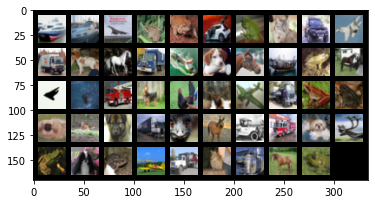

VAE reconstruction:


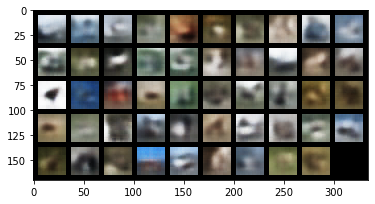

In [ ]:
images, labels = iter(test_cifar_loader).next()

# First visualise the original images
print('Original images')
show_image(make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualize_reconstructions(images, vae)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42, perplexity=50)
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(dataloader))
    imgs_.append(imgs)
    labels_.append(labels)

imgs = torch.cat(imgs_, dim = 0)
labels = torch.cat(labels_, dim = 0)

latent_z , _, _ = vae.encode(imgs.cuda())
tsne_z = tsne.fit_transform(latent_z.cpu().detach().numpy())
labels = labels.data.numpy()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12800 samples in 0.038s...
[t-SNE] Computed neighbors for 12800 samples in 11.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12800
[t-SNE] Computed conditional probabilities for sample 2000 / 12800
[t-SNE] Computed conditional probabilities for sample 3000 / 12800
[t-SNE] Computed conditional probabilities for sample 4000 / 12800
[t-SNE] Computed conditional probabilities for sample 5000 / 12800
[t-SNE] Computed conditional probabilities for sample 6000 / 12800
[t-SNE] Computed conditional probabilities for sample 7000 / 12800
[t-SNE] Computed conditional probabilities for sample 8000 / 12800
[t-SNE] Computed conditional probabilities for sample 9000 / 12800
[t-SNE] Computed conditional probabilities for sample 10000 / 12800
[t-SNE] Computed conditional probabilities for sample 11000 / 12800
[t-SNE] Computed conditional probabilities for sample 12000 / 12800
[t-SNE] Computed conditional probabilities for s

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

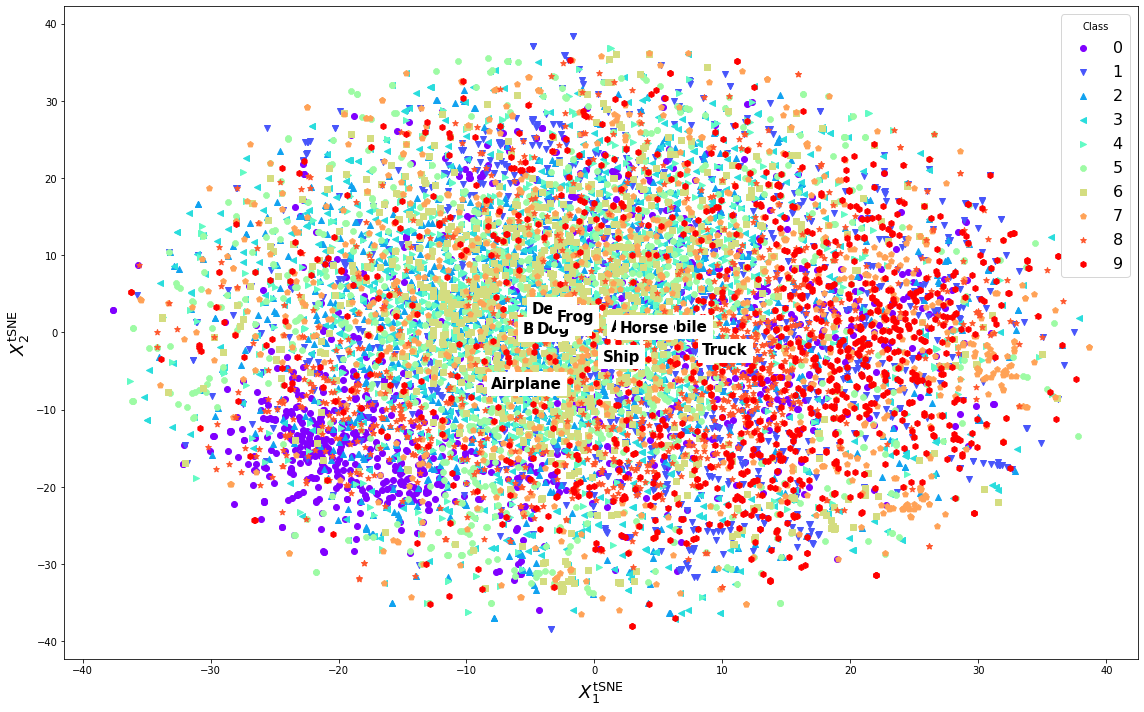

In [ ]:
fashion_labels = ["Airplane", "Automobile" ,"Bird", "Cat" ,"Deer","Dog", "Frog", "Horse", "Ship", "Truck"]
nr_c = 10
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_z[idxs, 0][:1000],
                tsne_z[idxs, 1][:1000],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.annotate(fashion_labels[iclass], 
                 np.average([tsne_z[idxs ,0], tsne_z[idxs ,1]], axis=1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=15, weight='bold',
                 color='black',
                 backgroundcolor='white') 
    plt.tight_layout()
    fig.savefig('tsne-pca-cifar.png')

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from time import time
from sklearn import metrics

In [ ]:
# accepts latent space from cluster GAN and vae and evaluates it. estimator - kmeans
def bench_latent_spaces(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean')))

In [ ]:
# kmeans on latent space
bench_latent_spaces(KMeans(n_clusters=10,init='k-means++',max_iter=1000, random_state=0), 'vae', latent_z.detach().cpu())

vae      	3.51s	342877	0.067	0.067	0.067	0.035	0.066	0.020


In [ ]:
# kmeans on tsne space
bench_latent_spaces(KMeans(n_clusters=10,init='k-means++',max_iter=1000, random_state=0), 'vae', tsne_z)

vae      	0.68s	749988	0.062	0.062	0.062	0.035	0.061	0.332


In [ ]:
#from scipy.optimize import linear_sum_assignment
from sklearn.utils.linear_assignment_ import linear_assignment
def clustering_acc(y_pred, y_true):
    D = int(max(y_pred.max(), y_true.max()) + 1)
    w = np.zeros((D, D), dtype=np.int32)
    for i in range(y_pred.size):
        idx1 = int(y_pred[i])
        idx2 = int(y_true[i])
        w[idx1, idx2] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
kmeans_mnist = KMeans(n_clusters=10,init='k-means++',max_iter=1000, random_state=0)
kmeans_labels = kmeans_mnist.fit(tsne_z)
clustering_acc(kmeans_labels.labels_, labels)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.197578125

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(tsne_z, kmeans_labels.labels_)

0.8152855763335711